In [92]:
%matplotlib widget

In [2]:
%matplotlib inline

In [81]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from numba import njit
import scipy.interpolate
import scipy.optimize
import os
import lmfit
from tqdm import tqdm
import datetime

from matplotlib import gridspec

import fit_functions
import nekhoroshev_tools

In [4]:
def mm_to_sigma(mm):
    return mm / (0.200 * np.sqrt(4.0 / 3.5))


def scale_factor(vals, sigma_barrier):
    return vals / 1.8e-11


def get_roi(df, from_t, to_t):
    return df[(df["t"] >= from_t) & (df["t"] <= to_t)]

In [70]:
# read csv file
loss_1_rs9 = pd.read_csv("timber/BLMEI.06L7.B1E10_TCP.A6L7.B1_LOSS_RS09.csv", header=1)
loss_1_rs6 = pd.read_csv("timber/BLMEI.06L7.B1E10_TCP.A6L7.B1_LOSS_RS06.csv", header=1)
loss_1_rs4 = pd.read_csv("timber/BLMEI.06L7.B1E10_TCP.A6L7.B1_LOSS_RS04.csv", header=1)
loss_2_rs9 = pd.read_csv("timber/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS09.csv", header=1)
loss_2_rs6 = pd.read_csv("timber/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS06.csv", header=1)
loss_2_rs4 = pd.read_csv("timber/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS04.csv", header=1)

barrier = pd.read_csv("timber/TCP.D6L7.B1_MEAS_LVDT_LU.csv", header=1)
barrier["Value"] = mm_to_sigma(barrier["Value"])

In [71]:
def utc_time_to_seconds(df):
    df["t"] = df["Timestamp (UTC_TIME)"].apply(
        lambda x: (
            datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") - datetime.datetime.strptime(loss_1_rs9["Timestamp (UTC_TIME)"].iloc[0], "%Y-%m-%d %H:%M:%S.%f")).total_seconds()
    )
    return df

In [72]:
def utc_time_to_datetime(df):
    df["datetime"] = df["Timestamp (UTC_TIME)"].apply(
        lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
    )
    return df

In [73]:
loss_1_rs9 = utc_time_to_seconds(loss_1_rs9)
loss_1_rs6 = utc_time_to_seconds(loss_1_rs6)
loss_1_rs4 = utc_time_to_seconds(loss_1_rs4)
loss_2_rs9 = utc_time_to_seconds(loss_2_rs9)
loss_2_rs6 = utc_time_to_seconds(loss_2_rs6)
loss_2_rs4 = utc_time_to_seconds(loss_2_rs4)

barrier = utc_time_to_seconds(barrier)

In [74]:
loss_1_rs9 = utc_time_to_datetime(loss_1_rs9)
loss_1_rs6 = utc_time_to_datetime(loss_1_rs6)
loss_1_rs4 = utc_time_to_datetime(loss_1_rs4)
loss_2_rs9 = utc_time_to_datetime(loss_2_rs9)
loss_2_rs6 = utc_time_to_datetime(loss_2_rs6)
loss_2_rs4 = utc_time_to_datetime(loss_2_rs4)

barrier = utc_time_to_datetime(barrier)

In [75]:
barrier["datetime"]

0      2017-08-06 05:39:05.008
1      2017-08-06 05:39:19.009
2      2017-08-06 05:45:47.017
3      2017-08-06 05:46:30.018
4      2017-08-06 06:16:11.079
                 ...          
1172   2017-08-07 00:12:29.088
1173   2017-08-07 00:12:40.089
1174   2017-08-07 00:12:53.090
1175   2017-08-07 00:13:14.091
1176   2017-08-07 00:14:09.092
Name: datetime, Length: 1177, dtype: datetime64[ns]

In [76]:
loss_1_rs9

,Timestamp (UTC_TIME),Value,t,datetime
0,2017-08-06 05:32:18.000,0.000017,0.0,2017-08-06 05:32:18
1,2017-08-06 05:32:19.000,0.000010,1.0,2017-08-06 05:32:19
2,2017-08-06 05:32:20.000,0.000007,2.0,2017-08-06 05:32:20
3,2017-08-06 05:32:21.000,0.000005,3.0,2017-08-06 05:32:21
4,2017-08-06 05:32:23.000,0.000005,5.0,2017-08-06 05:32:23
...,...,...,...,...
65609,2017-08-07 00:11:18.000,0.000002,67140.0,2017-08-07 00:11:18
65610,2017-08-07 00:12:18.000,0.000002,67200.0,2017-08-07 00:12:18
65611,2017-08-07 00:13:18.000,0.000002,67260.0,2017-08-07 00:13:18
65612,2017-08-07 00:14:18.000,0.000002,67320.0,2017-08-07 00:14:18


(3.5, 5.5)

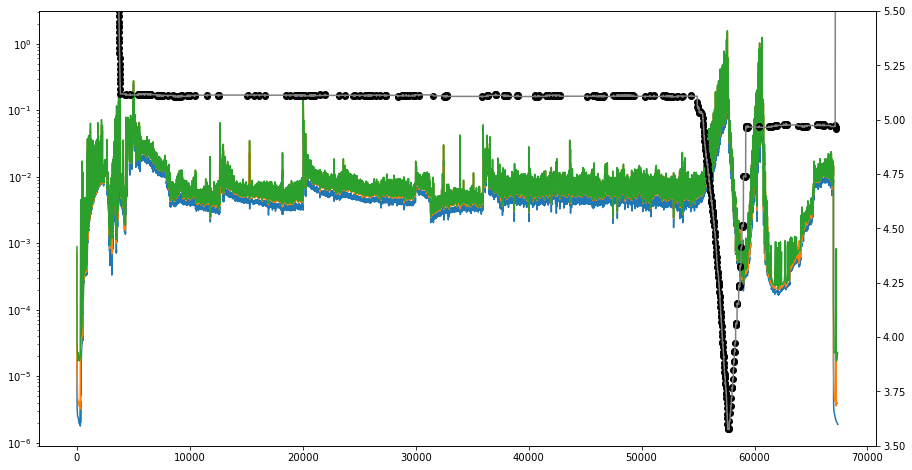

In [77]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs9["t"], loss_1_rs9["Value"], label="RS9")
plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_1_rs4["t"], loss_1_rs4["Value"], label="RS4")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs9["t"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

plt.ylim(3.5, 5.5)

In [78]:
from_t = 57700.0
to_t = 59250.0

In [79]:
loss_1_rs4 = get_roi(loss_1_rs4, from_t, to_t)
loss_1_rs6 = get_roi(loss_1_rs6, from_t, to_t)
loss_1_rs9 = get_roi(loss_1_rs9, from_t, to_t)
loss_2_rs4 = get_roi(loss_2_rs4, from_t, to_t)
loss_2_rs6 = get_roi(loss_2_rs6, from_t, to_t)
loss_2_rs9 = get_roi(loss_2_rs9, from_t, to_t)

barrier = get_roi(barrier, from_t, to_t)

(3.5, 5.5)

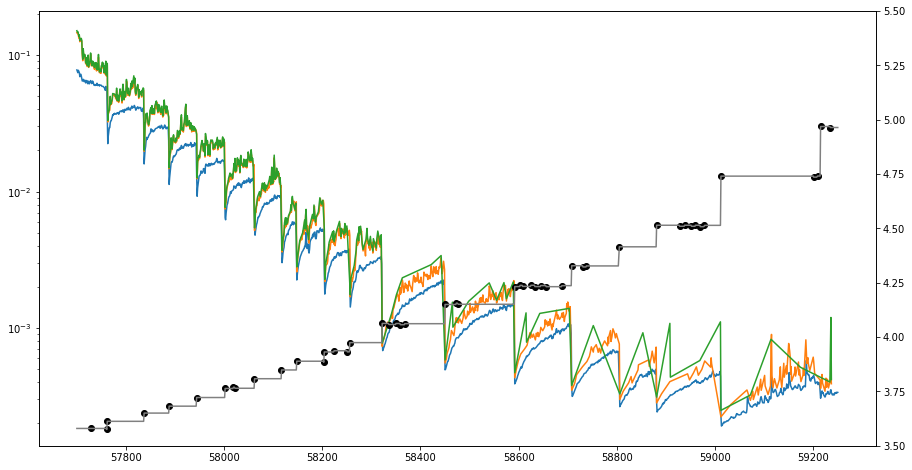

In [80]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs9["t"], loss_1_rs9["Value"], label="RS9")
plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_1_rs4["t"], loss_1_rs4["Value"], label="RS4")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs9["t"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

plt.ylim(3.5, 5.5)

In [13]:
b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)

def get_idx_vals(df):
    diffs = np.diff(b_func(df["t"]))
    idxs = np.where(diffs > 0.01)[0]
    vals = loss_1_rs9["t"].iloc[np.where(diffs > 0.01)]
    return idxs, vals

In [14]:
idx_loss_1_rs9, vals_loss_1_rs9 = get_idx_vals(loss_1_rs9)
idx_loss_1_rs6, vals_loss_1_rs6 = get_idx_vals(loss_1_rs6)
idx_loss_1_rs4, vals_loss_1_rs4 = get_idx_vals(loss_1_rs4)
idx_loss_2_rs9, vals_loss_2_rs9 = get_idx_vals(loss_2_rs9)
idx_loss_2_rs6, vals_loss_2_rs6 = get_idx_vals(loss_2_rs6)
idx_loss_2_rs4, vals_loss_2_rs4 = get_idx_vals(loss_2_rs4)

(3.5, 5.5)

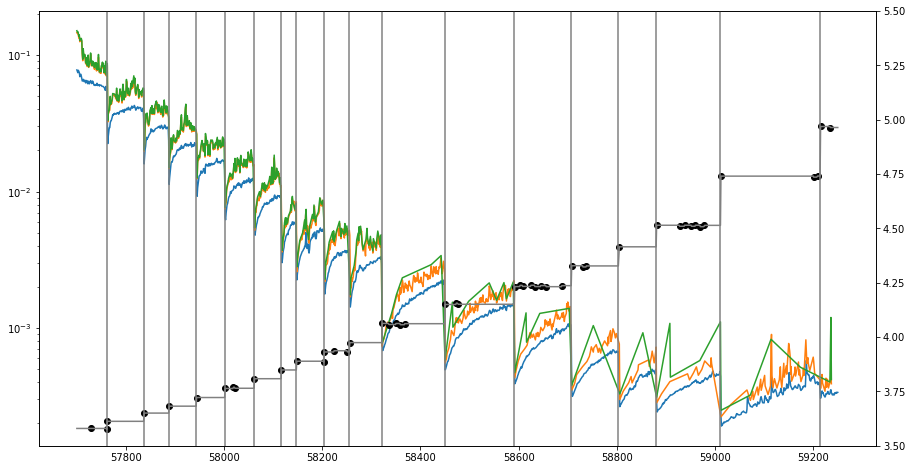

In [15]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs9["t"], loss_1_rs9["Value"], label="RS9")
plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_1_rs4["t"], loss_1_rs4["Value"], label="RS4")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs9["t"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

for v in vals_loss_1_rs9:
    plt.axvline(v, color="grey")

plt.ylim(3.5, 5.5)

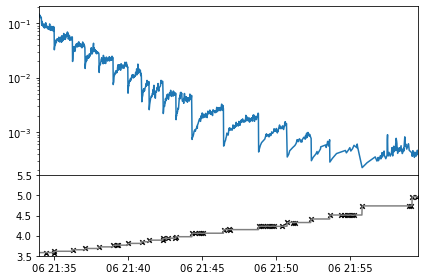

In [96]:
fig = plt.figure(figsize=(6, 4))

gs = gridspec.GridSpec(2, 1, height_ratios=[2.1, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

#plt.plot(loss_1_rs9["t"], loss_1_rs9["Value"], label="RS9")
ax0.plot(loss_1_rs6["datetime"], loss_1_rs6["Value"], label="RS6")
#plt.plot(loss_1_rs4["t"], loss_1_rs4["Value"], label="RS4")

ax0.set_yscale("log")


ax1.scatter(barrier["datetime"], barrier["Value"], label="Barrier", color="black", s=20, marker="x")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
ax1.plot(loss_1_rs9["datetime"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

# for v in vals_loss_1_rs9:
    # ax1.axvline(v, color="grey", linestyle="--")
    # ax0.axvline(v, color="grey", linestyle="--")

ax1.set_ylim(3.5, 5.5)
ax1.set_xlim(loss_1_rs6["datetime"].iloc[0], loss_1_rs6["datetime"].iloc[-1])

plt.tight_layout()
plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)

In [16]:
def get_slices(df, vals, idxs):
    slices = []

    for i in range(len(vals) - 1):
        slices.append((
            df["t"].iloc[idxs[i]: idxs[i+1]].values,
            df["Value"].iloc[idxs[i]: idxs[i+1]].values,
            np.mean(b_func(df["t"].iloc[idxs[i]+1: idxs[i+1]-1].values)),
            (idxs[i], idxs[i+1])
        ))
    return slices

In [17]:
def reset_indexes(df, slices, idxs, slice_val=5):
    new_slices = []
    for i, s in enumerate(slices[:]):
        if i == 0:
            new_left = np.argmin(s[1][:slice_val]) + s[3][0]
        else:
            data = np.concatenate((
                slices[i-1][1][-slice_val:],
                slices[i][1][:slice_val]
            ))
            rel_index = np.argmin(data)
            if rel_index < slice_val:
                new_left = slices[i-1][3][1] + rel_index
            else:
                new_left = slices[i][3][0] + rel_index - slice_val
        
        if i == len(slices) - 1:
            new_right = np.argmax(s[1][-slice_val:]) + s[3][1] - slice_val
        else:
            data = np.concatenate((
                slices[i][1][-slice_val:],
                slices[i+1][1][:slice_val]
            ))
            rel_index = np.argmax(data)
            if rel_index < slice_val:
                new_right = slices[i][3][1] + rel_index - slice_val
            else:
                new_right = slices[i+1][3][0] + rel_index - slice_val

        new_slices.append((
            df["t"].values[new_left: new_right],
            df["Value"].values[new_left: new_right],
            np.mean(b_func(df["t"].values[idxs[i]+1: idxs[i+1]-1])),
            (new_left, new_right)
        ))
    return new_slices

In [18]:
loss_1_rs9["t"].values

array([57700., 57701., 57702., ..., 59248., 59249., 59250.])

In [19]:
slice_loss_1_rs9 = reset_indexes(loss_1_rs9, get_slices(loss_1_rs9, vals_loss_1_rs9, idx_loss_1_rs9), idx_loss_1_rs9)
slice_loss_1_rs6 = reset_indexes(loss_1_rs6, get_slices(loss_1_rs6, vals_loss_1_rs6, idx_loss_1_rs6), idx_loss_1_rs6)
slice_loss_1_rs4 = reset_indexes(loss_1_rs4, get_slices(loss_1_rs4, vals_loss_1_rs4, idx_loss_1_rs4), idx_loss_1_rs4)
slice_loss_2_rs4 = reset_indexes(loss_2_rs4, get_slices(loss_2_rs4, vals_loss_2_rs4, idx_loss_2_rs4), idx_loss_2_rs4)
slice_loss_2_rs6 = reset_indexes(loss_2_rs6, get_slices(loss_2_rs6, vals_loss_2_rs6, idx_loss_2_rs6), idx_loss_2_rs6)
slice_loss_2_rs9 = reset_indexes(loss_2_rs9, get_slices(loss_2_rs9, vals_loss_2_rs9, idx_loss_2_rs9), idx_loss_2_rs9)

/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


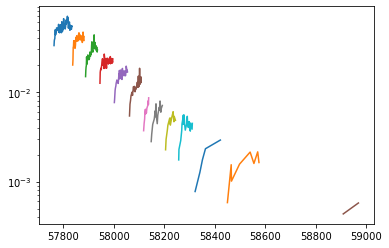

In [20]:
plt.figure()
for s in slice_loss_1_rs4:
    plt.plot(s[0], s[1])

plt.yscale("log")

In [21]:
slice_loss_2_rs6[0]

(array([57763., 57764., 57765., 57766., 57767., 57768., 57769., 57770.,
        57771., 57772., 57773., 57775., 57776., 57777., 57778., 57779.,
        57780., 57781., 57782., 57783., 57784., 57785., 57786., 57787.,
        57788., 57789., 57790., 57791., 57792., 57793., 57794., 57795.,
        57796., 57797., 57798., 57799., 57800., 57801., 57802., 57803.,
        57804., 57805., 57806., 57807., 57808., 57809., 57810., 57811.,
        57812., 57813., 57814., 57815., 57816., 57817., 57818., 57819.,
        57820., 57821., 57822., 57823., 57824., 57825., 57826., 57827.,
        57828., 57829., 57830., 57831., 57832., 57833., 57834., 57835.]),
 array([0.0326097 , 0.03601228, 0.03716121, 0.03695617, 0.03816343,
        0.04872223, 0.04140021, 0.0441488 , 0.04364539, 0.04656826,
        0.05249389, 0.05195407, 0.05096246, 0.05116113, 0.0516808 ,
        0.04926488, 0.04751003, 0.05842836, 0.04366095, 0.05094337,
        0.04672416, 0.04648306, 0.04683021, 0.05267171, 0.0551548 ,
        0.

In [22]:
def get_spline(slices):
    x = []
    y = []
    for s in slices:
        try:
            x.append(s[0][-1])
            y.append(s[1][-1])
        except:
            pass
    spline = scipy.interpolate.UnivariateSpline(
    np.asarray(x), np.log10(y), k=3, s=1) 

    return lambda x: np.power(10, spline(x))

In [23]:
spline_loss_1_rs9 = get_spline(slice_loss_1_rs9)
spline_loss_1_rs6 = get_spline(slice_loss_1_rs6)
spline_loss_1_rs4 = get_spline(slice_loss_1_rs4)
spline_loss_2_rs4 = get_spline(slice_loss_2_rs4)
spline_loss_2_rs6 = get_spline(slice_loss_2_rs6)
spline_loss_2_rs9 = get_spline(slice_loss_2_rs9)

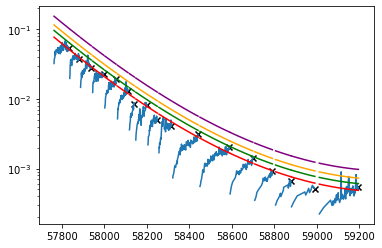

In [63]:
plt.figure()
for s in slice_loss_1_rs6:
    plt.plot(s[0], s[1], color="C0")
    plt.scatter([s[0][-1]], [s[1][-1]], color="black", marker="x")
    plt.plot(s[0], spline_loss_1_rs6(s[0]), color="red")
    plt.plot(s[0], spline_loss_1_rs6(s[0]) * 1.25, color="green")
    plt.plot(s[0], spline_loss_1_rs6(s[0]) * 1.5, color="orange")
    plt.plot(s[0], spline_loss_1_rs6(s[0]) * 2.0, color="purple")

plt.yscale("log")

In [25]:
def compose_fit_lists(slices, spline, samples_per_slice=20, spline_multiplier=1.0):
    x_raw = []
    all_raw = []
    x_list = []
    y_list = []

    for i in range(1, len(slices)):
        try:
            from_value = slices[i-1][2]
            to_value = slices[i][2]
            times = slices[i][0] - slices[i][0][0] 
            times[0] += times[1] * 0.2 # so that it's not zero
            the_function = spline(slices[i][0]) * spline_multiplier
            values = slices[i][1] / the_function
            
            # x_raw.append(slices[i][0])
            # y_raw.append(values)

            if len(values) < samples_per_slice + 1:
                idxs = np.arange(1, len(values))
            else:
                idxs = np.linspace(1, len(values), samples_per_slice, dtype=int, endpoint=False)
            all_raw.append((slices[i][0], values-1))
            
            values = values[idxs]
            times = times[idxs]

            x_raw.append(slices[i][0][idxs])

            x_list.append(("forward", from_value, to_value, times))
            y_list.append(values-1)
        except:
            pass    
    return x_raw, all_raw, x_list, y_list

In [26]:
x_raw, y_raw, x_list, y_list = compose_fit_lists(slice_loss_1_rs6, spline_loss_1_rs6)

In [27]:
_, _, x_list_loss_1_rs9, y_list_loss_1_rs9 = compose_fit_lists(slice_loss_1_rs9, spline_loss_1_rs9)
x_raw_loss_1_rs6, all_raw_loss_1_rs6, x_list_loss_1_rs6, y_list_loss_1_rs6 = compose_fit_lists(slice_loss_1_rs6, spline_loss_1_rs6)
_, _, x_list_loss_1_rs4, y_list_loss_1_rs4 = compose_fit_lists(slice_loss_1_rs4, spline_loss_1_rs4)

_, _, x_list_loss_2_rs4, y_list_loss_2_rs4 = compose_fit_lists(slice_loss_2_rs4, spline_loss_2_rs4)
x_raw_loss_2_rs6, all_raw_loss_2_rs6, x_list_loss_2_rs6, y_list_loss_2_rs6 = compose_fit_lists(slice_loss_2_rs6, spline_loss_2_rs6)
_, _, x_list_loss_2_rs9, y_list_loss_2_rs9 = compose_fit_lists(slice_loss_2_rs9, spline_loss_2_rs9)


In [28]:
x_raw_loss_1_rs6_mult_1_25, all_raw_loss_1_rs6_mult_1_25, x_list_loss_1_rs6_mult_1_25, y_list_loss_1_rs6_mult_1_25 = compose_fit_lists(slice_loss_1_rs6, spline_loss_1_rs6, spline_multiplier=1.25)

x_raw_loss_2_rs6_mult_1_25, all_raw_loss_2_rs6_mult_1_25, x_list_loss_2_rs6_mult_1_25, y_list_loss_2_rs6_mult_1_25 = compose_fit_lists(slice_loss_2_rs6, spline_loss_2_rs6, spline_multiplier=1.25)


In [29]:
x_raw_loss_1_rs6_mult_1_5, all_raw_loss_1_rs6_mult_1_5, x_list_loss_1_rs6_mult_1_5, y_list_loss_1_rs6_mult_1_5 = compose_fit_lists(slice_loss_1_rs6, spline_loss_1_rs6, spline_multiplier=1.5)

x_raw_loss_2_rs6_mult_1_5, all_raw_loss_2_rs6_mult_1_5, x_list_loss_2_rs6_mult_1_5, y_list_loss_2_rs6_mult_1_5 = compose_fit_lists(slice_loss_2_rs6, spline_loss_2_rs6, spline_multiplier=1.5)


In [30]:
x_raw_loss_1_rs6_mult_2_0, all_raw_loss_1_rs6_mult_2_0, x_list_loss_1_rs6_mult_2_0, y_list_loss_1_rs6_mult_2_0 = compose_fit_lists(slice_loss_1_rs6, spline_loss_1_rs6, spline_multiplier=2.0)

x_raw_loss_2_rs6_mult_2_0, all_raw_loss_2_rs6_mult_2_0, x_list_loss_2_rs6_mult_2_0, y_list_loss_2_rs6_mult_2_0 = compose_fit_lists(slice_loss_2_rs6, spline_loss_2_rs6, spline_multiplier=2.0)


In [31]:
x_list_loss_2_rs6[3][-1]

array([ 1.,  3.,  6.,  8., 11., 14., 16., 19., 22., 24., 27., 30., 32.,
       35., 38., 40., 43., 46., 48., 51.])

In [32]:
with open("to_fit_b1_v.pkl", "wb") as f:
    pickle.dump(
        {
            #"loss_1_rs9": (x_list_loss_1_rs9, y_list_loss_1_rs9),
            "loss_1_rs6": (x_list_loss_1_rs6, y_list_loss_1_rs6),
            "loss_1_rs6_mult_1_25": (x_list_loss_1_rs6_mult_1_25, y_list_loss_1_rs6_mult_1_25),
            "loss_1_rs6_mult_1_5": (x_list_loss_1_rs6_mult_1_5, y_list_loss_1_rs6_mult_1_5),
            "loss_1_rs6_mult_2_0": (x_list_loss_1_rs6_mult_2_0, y_list_loss_1_rs6_mult_2_0),
            #"loss_1_rs4": (x_list_loss_1_rs4, y_list_loss_1_rs4),
            #"loss_2_rs4": (x_list_loss_2_rs4, y_list_loss_2_rs4),
            "loss_2_rs6": (x_list_loss_2_rs6, y_list_loss_2_rs6),
            "loss_2_rs6_mult_1_25": (x_list_loss_2_rs6_mult_1_25, y_list_loss_2_rs6_mult_1_25),
            "loss_2_rs6_mult_1_5": (x_list_loss_2_rs6_mult_1_5, y_list_loss_2_rs6_mult_1_5),
            "loss_2_rs6_mult_2_0": (x_list_loss_2_rs6_mult_2_0, y_list_loss_2_rs6_mult_2_0),
            #"loss_2_rs9": (x_list_loss_2_rs9, y_list_loss_2_rs9),
        }
        ,f
    )

In [33]:
fit_result = {}
for key in ["loss_1_rs6", "loss_1_rs6_mult_1_25", "loss_1_rs6_mult_1_5", "loss_1_rs6_mult_2_0", "loss_2_rs6", "loss_2_rs6_mult_1_25", "loss_2_rs6_mult_1_5", "loss_2_rs6_mult_2_0"]:
    with open(f"fit_result_b1_v_{key}_single_kmax_2.1.pkl", "rb") as f:
        fit_result[key] = pickle.load(f)

In [34]:
fit_result["loss_1_rs6"][0]

In [35]:
fit_result["loss_1_rs6_mult_1_25"][0]

In [36]:
fit_result["loss_1_rs6_mult_1_5"][0]

In [37]:
fit_result["loss_1_rs6_mult_2_0"][0]

In [46]:
x_list_loss_1_rs6[0]

('forward',
 3.6125702069302403,
 3.6504544879713263,
 array([ 1.,  3.,  5.,  7., 10., 12., 14., 16., 19., 21., 23., 25., 28.,
        30., 32., 34., 37., 39., 41., 43.]))

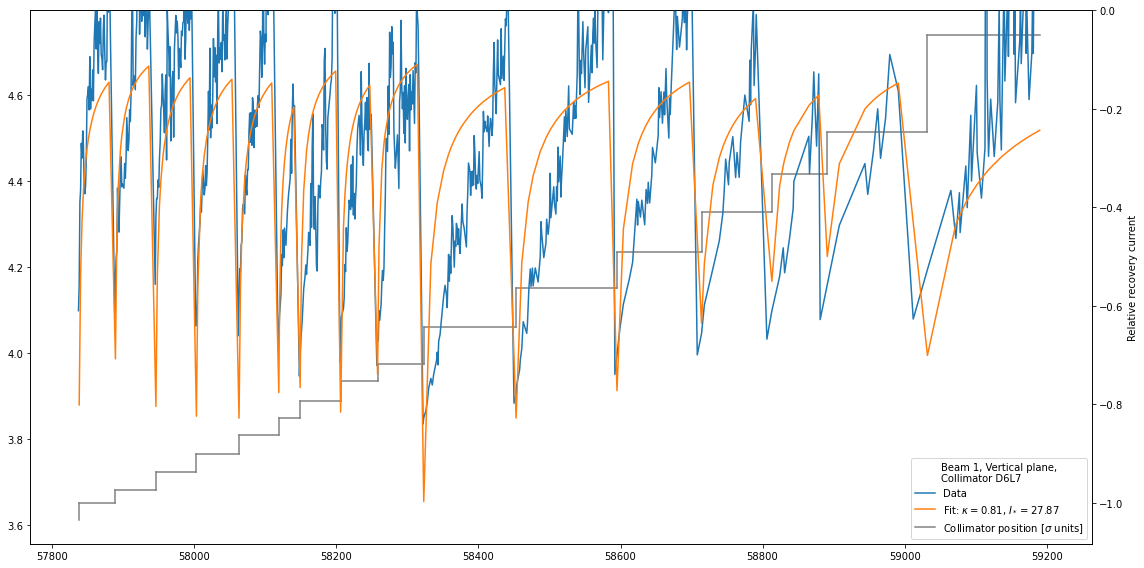

In [64]:
plt.figure(figsize=(16,8))

for i, (t, x) in enumerate(zip(x_raw_loss_1_rs6, x_list_loss_1_rs6)):
    plt.plot([t[0], t[0]], [x[1], x[2]], color="grey")
    if i == len(x_raw_loss_1_rs6) - 1:
        plt.plot([t[0], t[-1]], [x[2], x[2]], color="grey", label="Fit range")
    else:
        plt.plot([t[0], x_raw_loss_1_rs6[i+1][0]], [x[2], x[2]], color="grey")

plt.twinx()

tmp_times = np.array([])
tmp_x = np.array([])
tmp_y = np.array([])

for x in x_raw_loss_1_rs6:
    tmp_times = np.append(tmp_times, x)

for data in all_raw_loss_1_rs6:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])
plt.plot(tmp_x, tmp_y, label="Data")

plt.plot(tmp_times, fit_result["loss_1_rs6"][2][:], label=f"Fit: $\\kappa = {fit_result['loss_1_rs6'][0].params['k'].value:.2f}$, $I_*={fit_result['loss_1_rs6'][0].params['I_star'].value:.2f}$")

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")

plt.plot([], [], label="Collimator position $[\\sigma$ units$]$", color="grey")
plt.legend(title="Beam 1, Vertical plane,\nCollimator D6L7", loc="lower right")

plt.tight_layout()
#plt.savefig("figs/b1_v_fit_single_kmax_2.1.jpg", dpi=300)

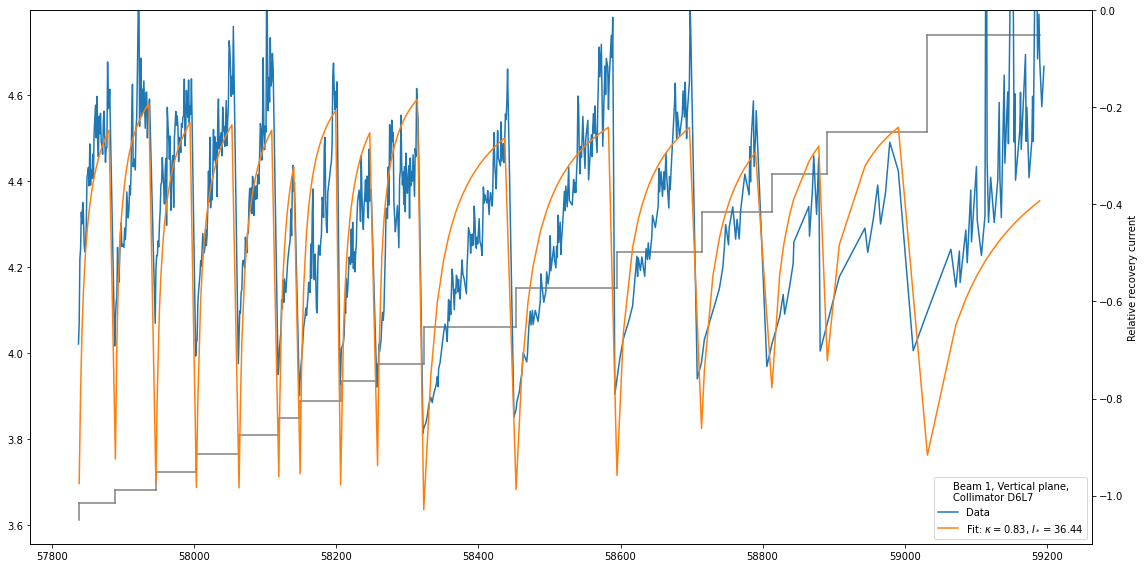

In [65]:
plt.figure(figsize=(16,8))

for i, (t, x) in enumerate(zip(x_raw_loss_1_rs6, x_list_loss_1_rs6)):
    plt.plot([t[0], t[0]], [x[1], x[2]], color="grey")
    if i == len(x_raw_loss_1_rs6) - 1:
        plt.plot([t[0], t[-1]], [x[2], x[2]], color="grey", label="Fit range")
    else:
        plt.plot([t[0], x_raw_loss_1_rs6[i+1][0]], [x[2], x[2]], color="grey")

plt.twinx()

tmp_times = np.array([])
tmp_x = np.array([])
tmp_y = np.array([])

for x in x_raw_loss_1_rs6_mult_1_25:
    tmp_times = np.append(tmp_times, x)

for data in all_raw_loss_1_rs6_mult_1_25:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])
plt.plot(tmp_x, tmp_y, label="Data")

plt.plot(tmp_times, fit_result["loss_1_rs6_mult_1_25"][2][:], label=f"Fit: $\\kappa = {fit_result['loss_1_rs6_mult_1_25'][0].params['k'].value:.2f}$, $I_*={fit_result['loss_1_rs6_mult_1_25'][0].params['I_star'].value:.2f}$")

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")

plt.legend(title="Beam 1, Vertical plane,\nCollimator D6L7")

plt.tight_layout()
#plt.savefig("figs/b1_v_fit_single_kmax_2.1.jpg", dpi=300)

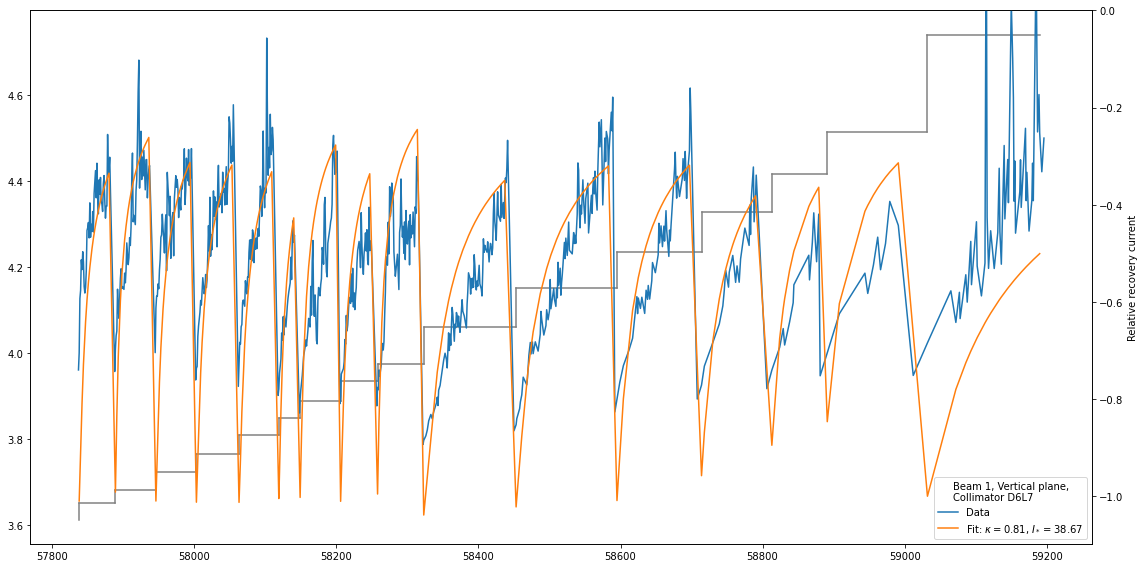

In [66]:
plt.figure(figsize=(16,8))

for i, (t, x) in enumerate(zip(x_raw_loss_1_rs6, x_list_loss_1_rs6)):
    plt.plot([t[0], t[0]], [x[1], x[2]], color="grey")
    if i == len(x_raw_loss_1_rs6) - 1:
        plt.plot([t[0], t[-1]], [x[2], x[2]], color="grey", label="Fit range")
    else:
        plt.plot([t[0], x_raw_loss_1_rs6[i+1][0]], [x[2], x[2]], color="grey")

plt.twinx()

tmp_times = np.array([])
tmp_x = np.array([])
tmp_y = np.array([])

for x in x_raw_loss_1_rs6_mult_1_5:
    tmp_times = np.append(tmp_times, x)

for data in all_raw_loss_1_rs6_mult_1_5:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])
plt.plot(tmp_x, tmp_y, label="Data")

plt.plot(tmp_times, fit_result["loss_1_rs6_mult_1_5"][2][:], label=f"Fit: $\\kappa = {fit_result['loss_1_rs6_mult_1_5'][0].params['k'].value:.2f}$, $I_*={fit_result['loss_1_rs6_mult_1_5'][0].params['I_star'].value:.2f}$")

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")

plt.legend(title="Beam 1, Vertical plane,\nCollimator D6L7")

plt.tight_layout()
#plt.savefig("figs/b1_v_fit_single_kmax_2.1.jpg", dpi=300)

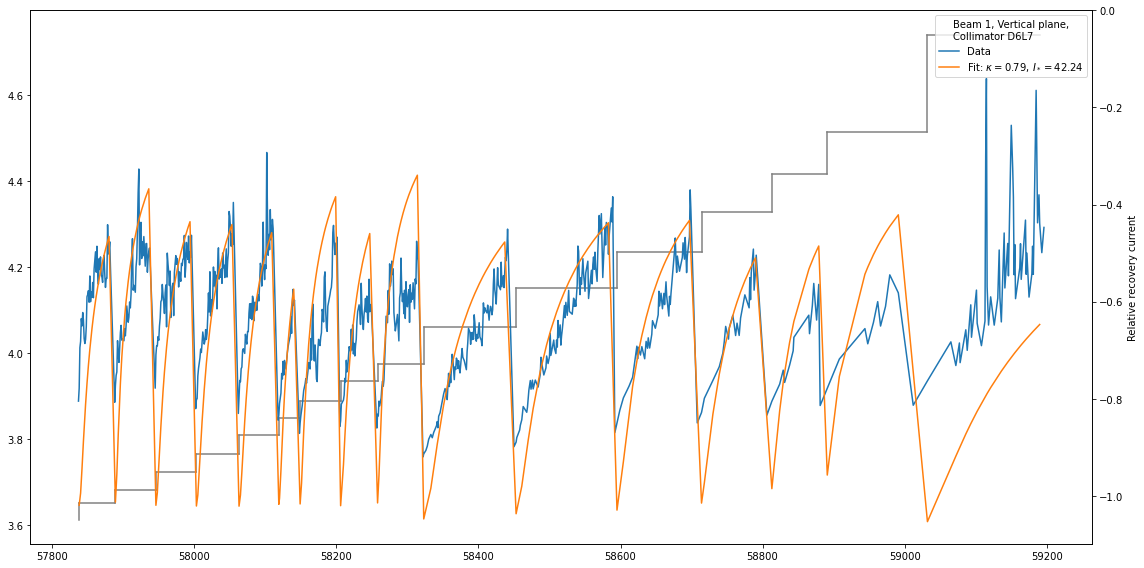

In [67]:
plt.figure(figsize=(16,8))

for i, (t, x) in enumerate(zip(x_raw_loss_1_rs6, x_list_loss_1_rs6)):
    plt.plot([t[0], t[0]], [x[1], x[2]], color="grey")
    if i == len(x_raw_loss_1_rs6) - 1:
        plt.plot([t[0], t[-1]], [x[2], x[2]], color="grey", label="Fit range")
    else:
        plt.plot([t[0], x_raw_loss_1_rs6[i+1][0]], [x[2], x[2]], color="grey")

plt.twinx()

tmp_times = np.array([])
tmp_x = np.array([])
tmp_y = np.array([])

for x in x_raw_loss_1_rs6_mult_2_0:
    tmp_times = np.append(tmp_times, x)

for data in all_raw_loss_1_rs6_mult_2_0:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])
plt.plot(tmp_x, tmp_y, label="Data")

plt.plot(tmp_times, fit_result["loss_1_rs6_mult_2_0"][2][:], label=f"Fit: $\\kappa = {fit_result['loss_1_rs6_mult_2_0'][0].params['k'].value:.2f}$, $I_*={fit_result['loss_1_rs6_mult_2_0'][0].params['I_star'].value:.2f}$")

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")

plt.legend(title="Beam 1, Vertical plane,\nCollimator D6L7")

plt.tight_layout()
#plt.savefig("figs/b1_v_fit_single_kmax_2.1.jpg", dpi=300)

In [56]:
fit_result["loss_2_rs6"][0]

In [57]:
fit_result["loss_2_rs6_mult_1_25"][0]

In [58]:
fit_result["loss_2_rs6_mult_1_5"][0]

In [59]:
fit_result["loss_2_rs6_mult_2_0"][0]

In [ ]:
x_list_loss_1_rs6[0]

('forward',
 3.6125702069302403,
 3.6504544879713263,
 array([ 1.,  3.,  5.,  7., 10., 12., 14., 16., 19., 21., 23., 25., 28.,
        30., 32., 34., 37., 39., 41., 43.]))

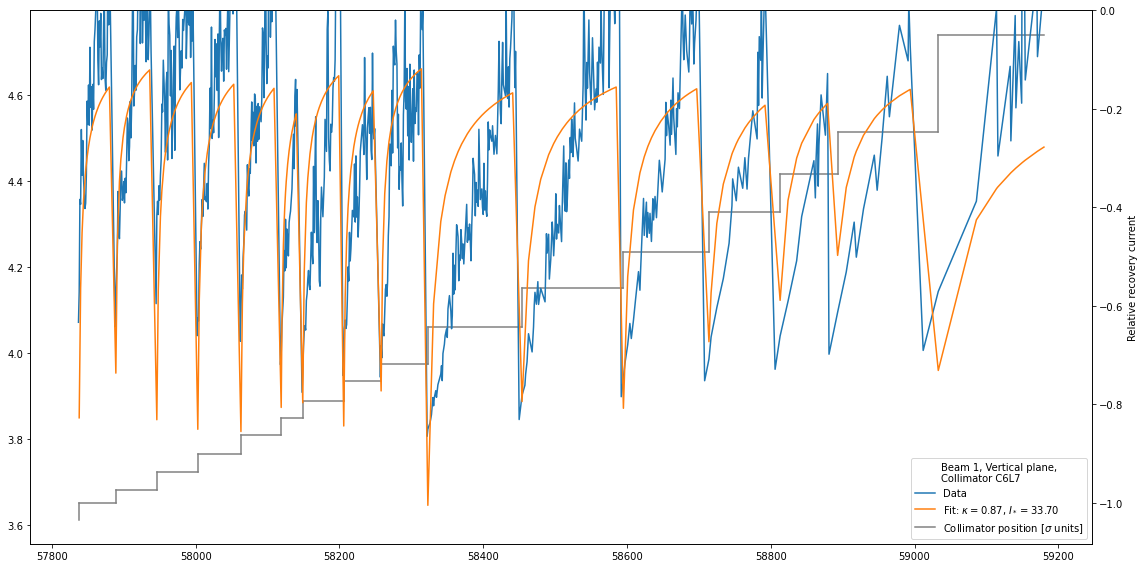

In [60]:
plt.figure(figsize=(16,8))

for i, (t, x) in enumerate(zip(x_raw_loss_2_rs6, x_list_loss_2_rs6)):
    plt.plot([t[0], t[0]], [x[1], x[2]], color="grey")
    if i == len(x_raw_loss_2_rs6) - 1:
        plt.plot([t[0], t[-1]], [x[2], x[2]], color="grey", label="Fit range")
    else:
        plt.plot([t[0], x_raw_loss_2_rs6[i+1][0]], [x[2], x[2]], color="grey")

plt.twinx()

tmp_times = np.array([])
tmp_x = np.array([])
tmp_y = np.array([])

for x in x_raw_loss_2_rs6:
    tmp_times = np.append(tmp_times, x)

for data in all_raw_loss_2_rs6:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])
plt.plot(tmp_x, tmp_y, label="Data")

plt.plot(tmp_times, fit_result["loss_2_rs6"][2][:], label=f"Fit: $\\kappa = {fit_result['loss_2_rs6'][0].params['k'].value:.2f}$, $I_*={fit_result['loss_2_rs6'][0].params['I_star'].value:.2f}$")

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")

plt.plot([], [], label="Collimator position $[\\sigma$ units$]$", color="grey")
plt.legend(title="Beam 1, Vertical plane,\nCollimator C6L7", loc="lower right")

plt.tight_layout()
#plt.savefig("figs/b1_v_fit_single_kmax_2.1.jpg", dpi=300)

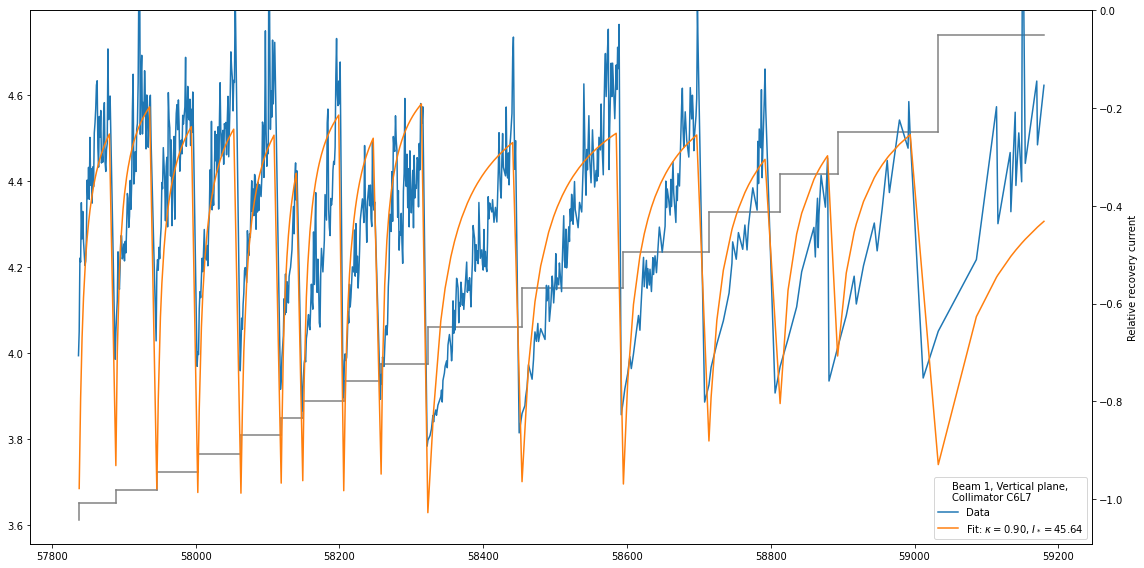

In [61]:
plt.figure(figsize=(16,8))

for i, (t, x) in enumerate(zip(x_raw_loss_2_rs6, x_list_loss_2_rs6)):
    plt.plot([t[0], t[0]], [x[1], x[2]], color="grey")
    if i == len(x_raw_loss_2_rs6) - 1:
        plt.plot([t[0], t[-1]], [x[2], x[2]], color="grey", label="Fit range")
    else:
        plt.plot([t[0], x_raw_loss_2_rs6[i+1][0]], [x[2], x[2]], color="grey")

plt.twinx()

tmp_times = np.array([])
tmp_x = np.array([])
tmp_y = np.array([])

for x in x_raw_loss_2_rs6_mult_1_25:
    tmp_times = np.append(tmp_times, x)

for data in all_raw_loss_2_rs6_mult_1_25:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])
plt.plot(tmp_x, tmp_y, label="Data")

plt.plot(tmp_times, fit_result["loss_2_rs6_mult_1_25"][2][:], label=f"Fit: $\\kappa = {fit_result['loss_2_rs6_mult_1_25'][0].params['k'].value:.2f}$, $I_*={fit_result['loss_2_rs6_mult_1_25'][0].params['I_star'].value:.2f}$")

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")

plt.legend(title="Beam 1, Vertical plane,\nCollimator C6L7")

plt.tight_layout()
#plt.savefig("figs/b1_v_fit_single_kmax_2.1.jpg", dpi=300)

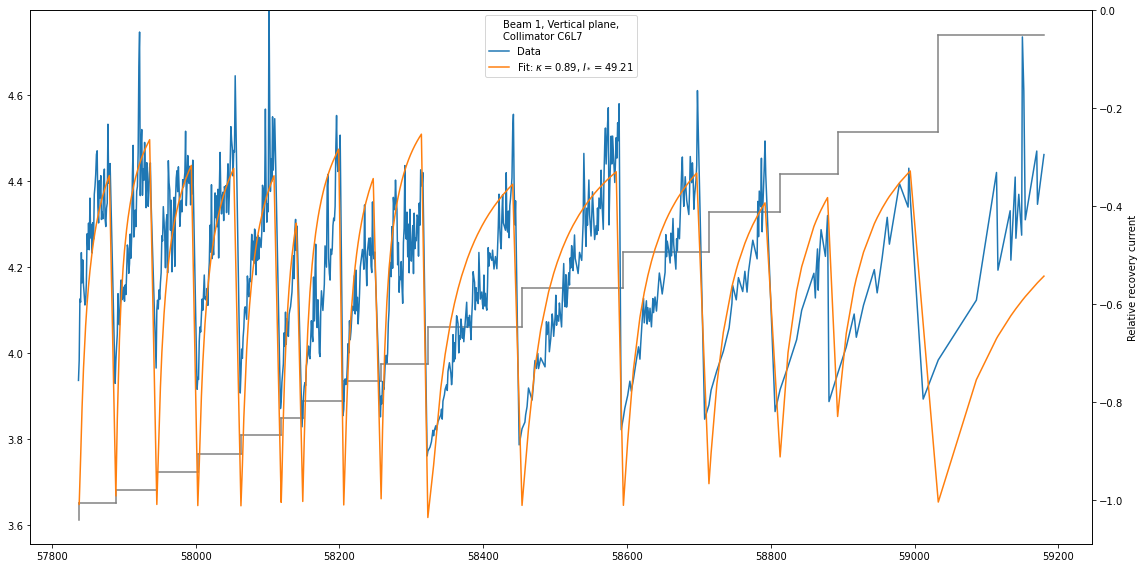

In [62]:
plt.figure(figsize=(16,8))

for i, (t, x) in enumerate(zip(x_raw_loss_2_rs6, x_list_loss_2_rs6)):
    plt.plot([t[0], t[0]], [x[1], x[2]], color="grey")
    if i == len(x_raw_loss_2_rs6) - 1:
        plt.plot([t[0], t[-1]], [x[2], x[2]], color="grey", label="Fit range")
    else:
        plt.plot([t[0], x_raw_loss_2_rs6[i+1][0]], [x[2], x[2]], color="grey")

plt.twinx()

tmp_times = np.array([])
tmp_x = np.array([])
tmp_y = np.array([])

for x in x_raw_loss_2_rs6_mult_1_5:
    tmp_times = np.append(tmp_times, x)

for data in all_raw_loss_2_rs6_mult_1_5:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])
plt.plot(tmp_x, tmp_y, label="Data")

plt.plot(tmp_times, fit_result["loss_2_rs6_mult_1_5"][2][:], label=f"Fit: $\\kappa = {fit_result['loss_2_rs6_mult_1_5'][0].params['k'].value:.2f}$, $I_*={fit_result['loss_2_rs6_mult_1_5'][0].params['I_star'].value:.2f}$")

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")

plt.legend(title="Beam 1, Vertical plane,\nCollimator C6L7")

plt.tight_layout()
#plt.savefig("figs/b1_v_fit_single_kmax_2.1.jpg", dpi=300)

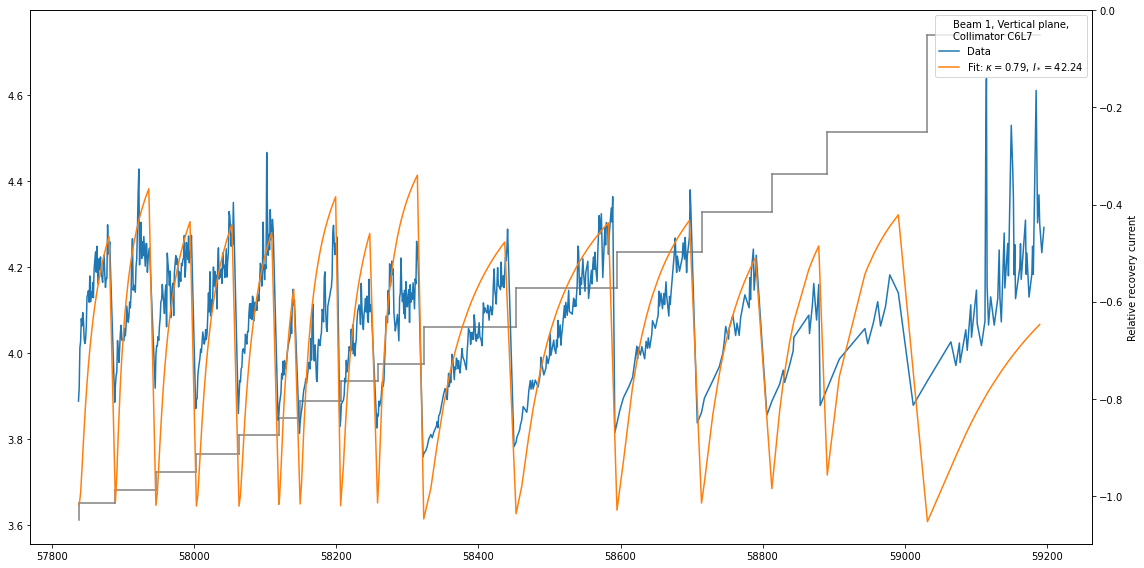

In [ ]:
plt.figure(figsize=(16,8))

for i, (t, x) in enumerate(zip(x_raw_loss_1_rs6, x_list_loss_1_rs6)):
    plt.plot([t[0], t[0]], [x[1], x[2]], color="grey")
    if i == len(x_raw_loss_1_rs6) - 1:
        plt.plot([t[0], t[-1]], [x[2], x[2]], color="grey", label="Fit range")
    else:
        plt.plot([t[0], x_raw_loss_1_rs6[i+1][0]], [x[2], x[2]], color="grey")

plt.twinx()

tmp_times = np.array([])
tmp_x = np.array([])
tmp_y = np.array([])

for x in x_raw_loss_1_rs6_mult_2_0:
    tmp_times = np.append(tmp_times, x)

for data in all_raw_loss_1_rs6_mult_2_0:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])
plt.plot(tmp_x, tmp_y, label="Data")

plt.plot(tmp_times, fit_result["loss_1_rs6_mult_2_0"][2][:], label=f"Fit: $\\kappa = {fit_result['loss_1_rs6_mult_2_0'][0].params['k'].value:.2f}$, $I_*={fit_result['loss_1_rs6_mult_2_0'][0].params['I_star'].value:.2f}$")

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")

plt.legend(title="Beam 1, Vertical plane,\nCollimator C6L7")

plt.tight_layout()
#plt.savefig("figs/b1_v_fit_single_kmax_2.1.jpg", dpi=300)

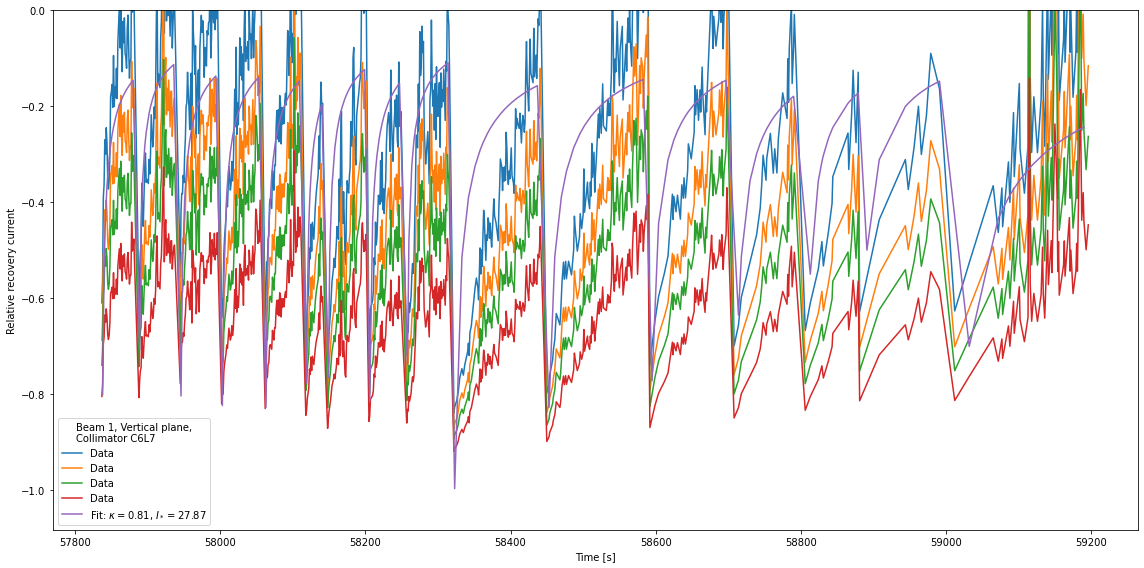

In [ ]:
plt.figure(figsize=(16,8))

tmp_times = np.array([])
tmp_x = np.array([])
tmp_y = np.array([])

for x in x_raw_loss_1_rs6:
    tmp_times = np.append(tmp_times, x)

for data in all_raw_loss_1_rs6:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])
plt.plot(tmp_x, tmp_y, label="Data")

tmp_x = np.array([])
tmp_y = np.array([])

for data in all_raw_loss_1_rs6_mult_1_25:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])
plt.plot(tmp_x, tmp_y, label="Data")

tmp_x = np.array([])
tmp_y = np.array([])

for data in all_raw_loss_1_rs6_mult_1_5:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])
plt.plot(tmp_x, tmp_y, label="Data")

tmp_x = np.array([])
tmp_y = np.array([])

for data in all_raw_loss_1_rs6_mult_2_0:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])
plt.plot(tmp_x, tmp_y, label="Data")


plt.plot(tmp_times, fit_result["loss_1_rs6"][2][:], label=f"Fit: $\\kappa = {fit_result['loss_1_rs6'][0].params['k'].value:.2f}$, $I_*={fit_result['loss_1_rs6'][0].params['I_star'].value:.2f}$")

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")

plt.legend(title="Beam 1, Vertical plane,\nCollimator C6L7")

plt.tight_layout()
plt.savefig("figs/b1_v_fit_single_kmax_2.1.jpg", dpi=300)

In [142]:
fit_result["loss_2_rs6"][0]

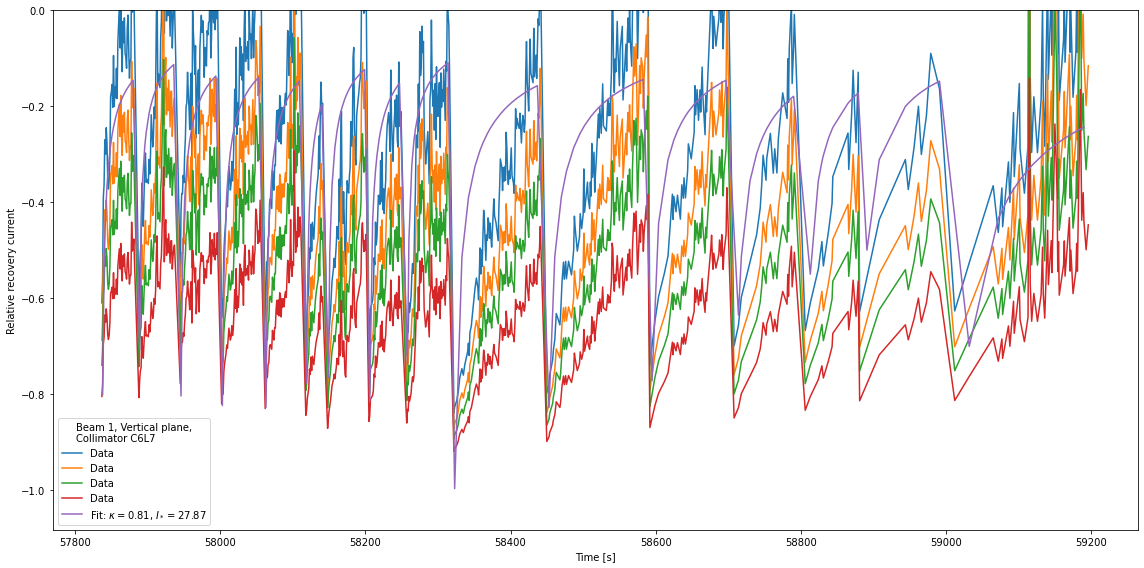

In [48]:
plt.figure(figsize=(16,8))

tmp_times = np.array([])
tmp_x = np.array([])
tmp_y = np.array([])

for x in x_raw_loss_1_rs6:
    tmp_times = np.append(tmp_times, x)

for data in all_raw_loss_1_rs6:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])
plt.plot(tmp_x, tmp_y, label="Data")

tmp_x = np.array([])
tmp_y = np.array([])

for data in all_raw_loss_1_rs6_mult_1_25:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])
plt.plot(tmp_x, tmp_y, label="Data")

tmp_x = np.array([])
tmp_y = np.array([])

for data in all_raw_loss_1_rs6_mult_1_5:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])
plt.plot(tmp_x, tmp_y, label="Data")

tmp_x = np.array([])
tmp_y = np.array([])

for data in all_raw_loss_1_rs6_mult_2_0:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])
plt.plot(tmp_x, tmp_y, label="Data")


plt.plot(tmp_times, fit_result["loss_1_rs6"][2][:], label=f"Fit: $\\kappa = {fit_result['loss_1_rs6'][0].params['k'].value:.2f}$, $I_*={fit_result['loss_1_rs6'][0].params['I_star'].value:.2f}$")

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")

plt.legend(title="Beam 1, Vertical plane,\nCollimator C6L7")

plt.tight_layout()
plt.savefig("figs/b1_v_fit_single_kmax_2.1.jpg", dpi=300)

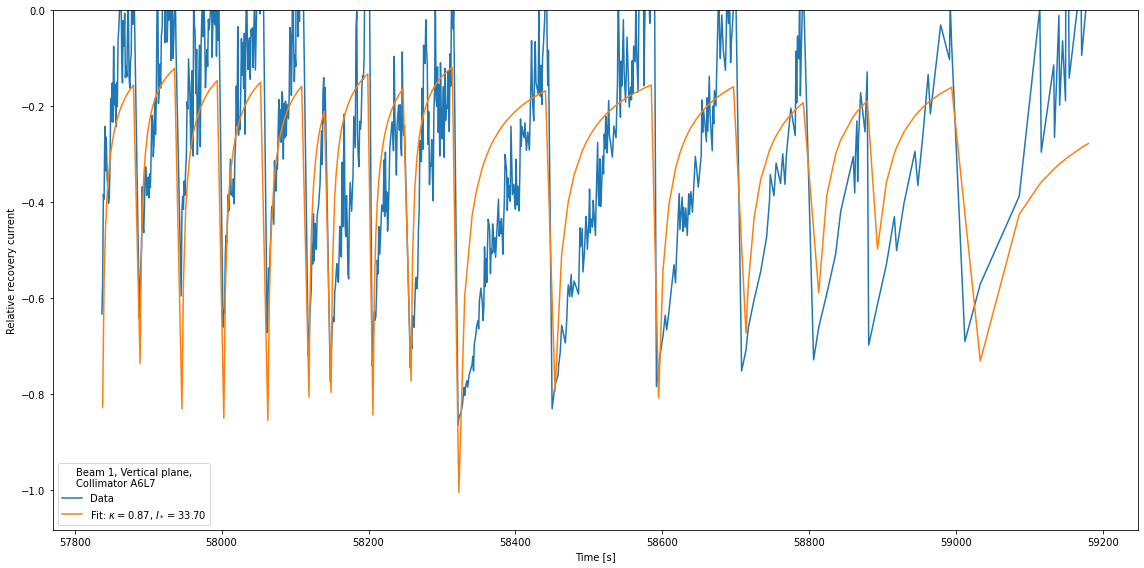

In [182]:
plt.figure(figsize=(16,8))

tmp_times = np.array([])
tmp_x = np.array([])
tmp_y = np.array([])

for x in x_raw_loss_2_rs6:
    tmp_times = np.append(tmp_times, x)

for data in all_raw_loss_2_rs6:
    tmp_x = np.append(tmp_x, data[0])
    tmp_y = np.append(tmp_y, data[1])

plt.plot(tmp_x, tmp_y, label="Data")
plt.plot(tmp_times, fit_result["loss_2_rs6"][2][:], label=f"Fit: $\\kappa = {fit_result['loss_2_rs6'][0].params['k'].value:.2f}$, $I_*={fit_result['loss_2_rs6'][0].params['I_star'].value:.2f}$")

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")

plt.legend(title="Beam 1, Vertical plane,\nCollimator A6L7")

plt.tight_layout()
plt.savefig("figs/b1_v_2_fit_single_kmax_2.1.jpg", dpi=300)

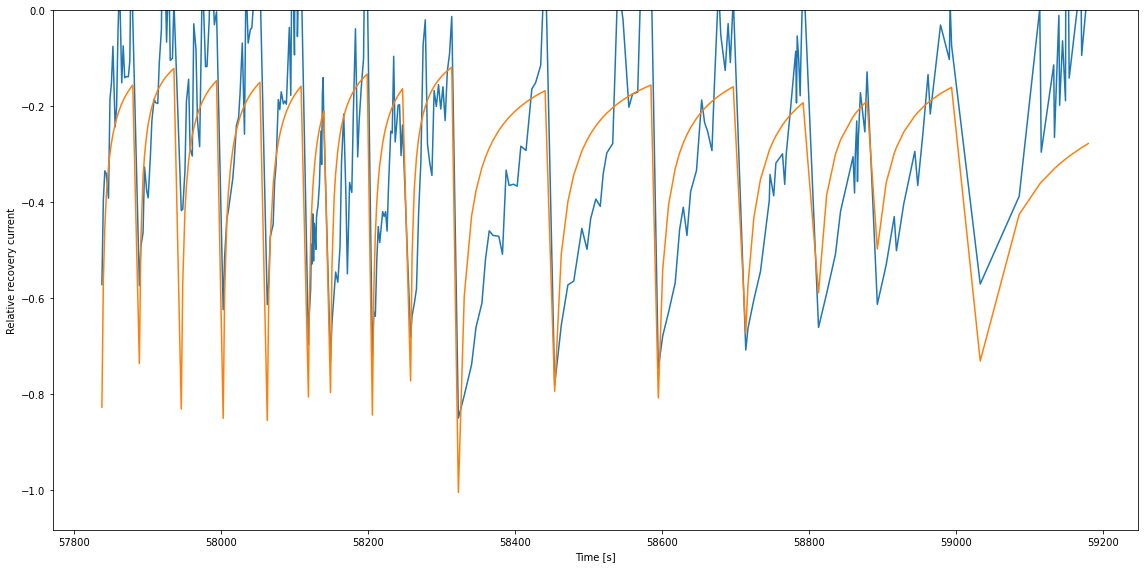

In [159]:
plt.figure(figsize=(16,8))
plt.plot(tmp_times, fit_result["loss_2_rs6"][1])
plt.plot(tmp_times, fit_result["loss_2_rs6"][2])

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")
plt.tight_layout()

In [65]:
fit_result = {}
for key in ["loss_1_rs9", "loss_1_rs6", "loss_1_rs4", "loss_2_rs4", "loss_2_rs6", "loss_2_rs9"]:
    with open(f"fit_result_{key}_single_kmax_2.0.pkl", "rb") as f:
        fit_result[key] = pickle.load(f)
    

In [80]:
pars = lmfit.Parameters()
pars.add("I_star", value=10.0, min=0.0)
pars.add("k", value=0.33, min=0.0)
pars.add("c", value=1.0, vary=False)

In [81]:
fit_c1, fit_c2 = fit_functions.ana_current(pars, x_list_loss_1_rs6, y_list_loss_1_rs6)

Values: I_star 10.0 k 0.33


In [29]:
x_list_loss_1_rs6[0][-1][0]

0.01

20.743337651704664


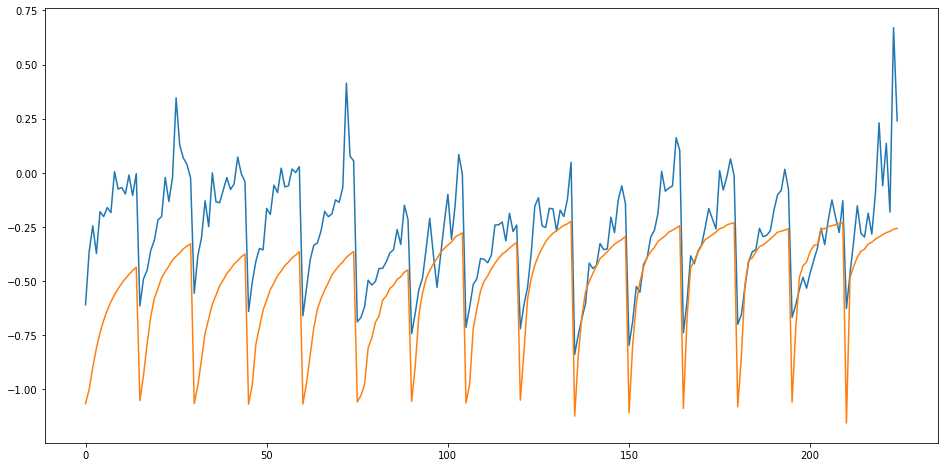

In [82]:
plt.figure(figsize=(16,8))

plt.plot(fit_c1)
plt.plot(fit_c2)
print(np.sum(((fit_c1 - fit_c2))**2))

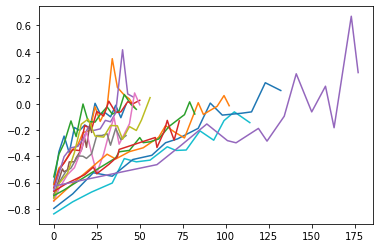

In [31]:
for x, y in zip(x_list_loss_1_rs6, y_list_loss_1_rs6):
    plt.plot(x[-1], y)

In [83]:
fit_result = lmfit.minimize(
    fit_functions.resid_func, pars, args=(x_list_loss_1_rs6, y_list_loss_1_rs6)
)
fit_c1, fit_c2 = fit_functions.ana_current(fit_result.params, x_list_loss_1_rs6, y_list_loss_1_rs6)

Values: I_star 10.0 k 0.33000000000000007 c 1.0
Error: 20.743337651704632
Values: I_star 10.0 k 0.33000000000000007 c 1.0
Error: 20.743337651704632
Values: I_star 10.0 k 0.33000000000000007 c 1.0
Error: 20.743337651704632
Values: I_star 10.000000162558123 k 0.33000000000000007 c 1.0
Error: 20.743341720996845
Values: I_star 10.0 k 0.33000000861466394 c 1.0
Error: 20.743331371060258
Values: I_star 13.762537971014638 k 0.507442331649876 c 1.0
Error: 7.507679848728185
Values: I_star 13.762538189984205 k 0.507442331649876 c 1.0
Error: 7.5076799335256945
Values: I_star 13.762537971014638 k 0.5074423442274547 c 1.0
Error: 7.507679662341905
Values: I_star 21.383600382087707 k 0.75301240791366 c 1.0
Error: 8.137343757271452
Values: I_star 15.84155429712024 k 0.5773098257876528 c 1.0
Error: 7.392987225094325
Values: I_star 15.841554547194168 k 0.5773098257876528 c 1.0
Error: 7.392987184785907
Values: I_star 15.84155429712024 k 0.5773098398442009 c 1.0
Error: 7.392987298521351
Values: I_star 20.4

7.307434574659089


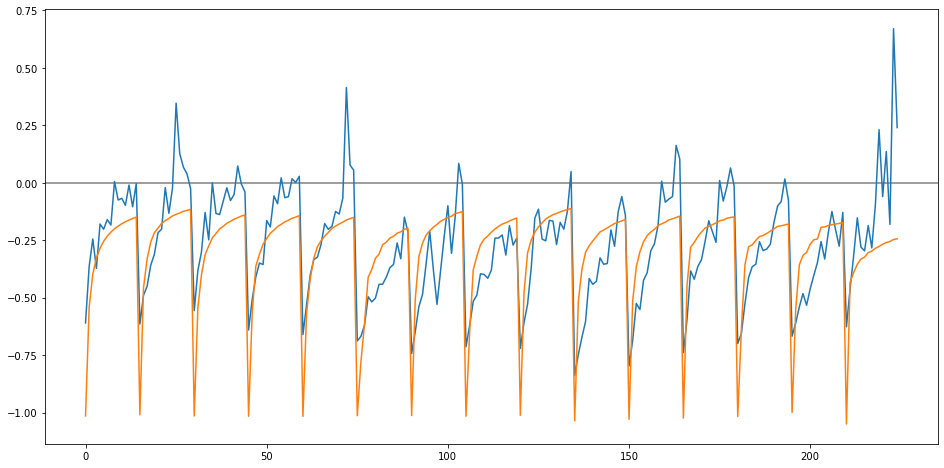

In [89]:
plt.figure(figsize=(16,8))

plt.axhline(0.0, color="grey")

plt.plot(fit_c1)
plt.plot(fit_c2)

print(np.sum(((fit_c1 - fit_c2))**2))

In [66]:
fit_result["loss_1_rs9"][0]

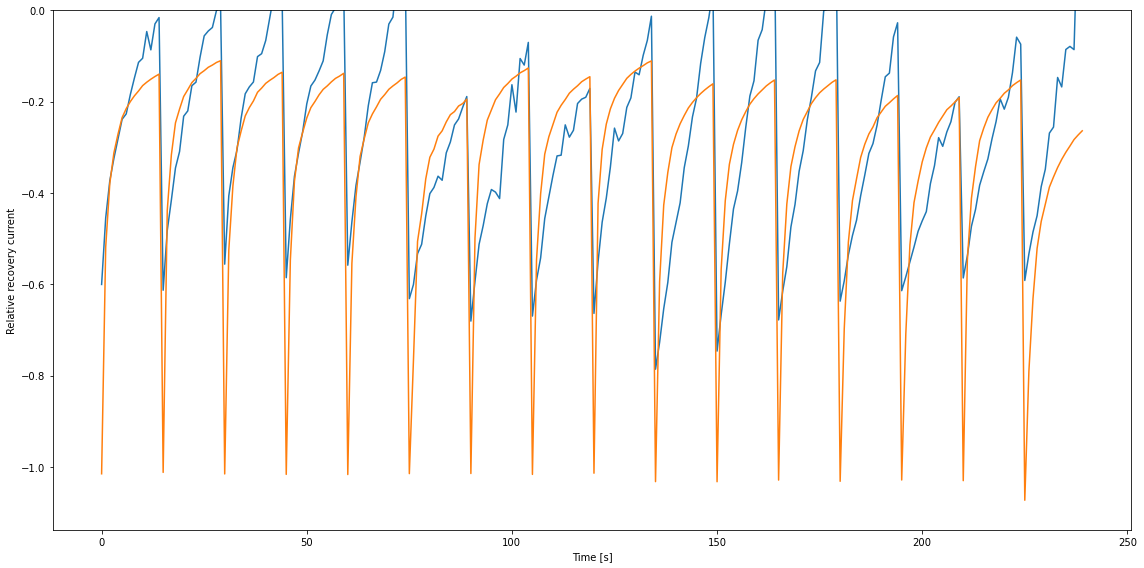

In [67]:
plt.figure(figsize=(16,8))
plt.plot(fit_result["loss_1_rs9"][1])
plt.plot(fit_result["loss_1_rs9"][2])

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")
plt.tight_layout()

In [68]:
fit_result["loss_1_rs6"][0]

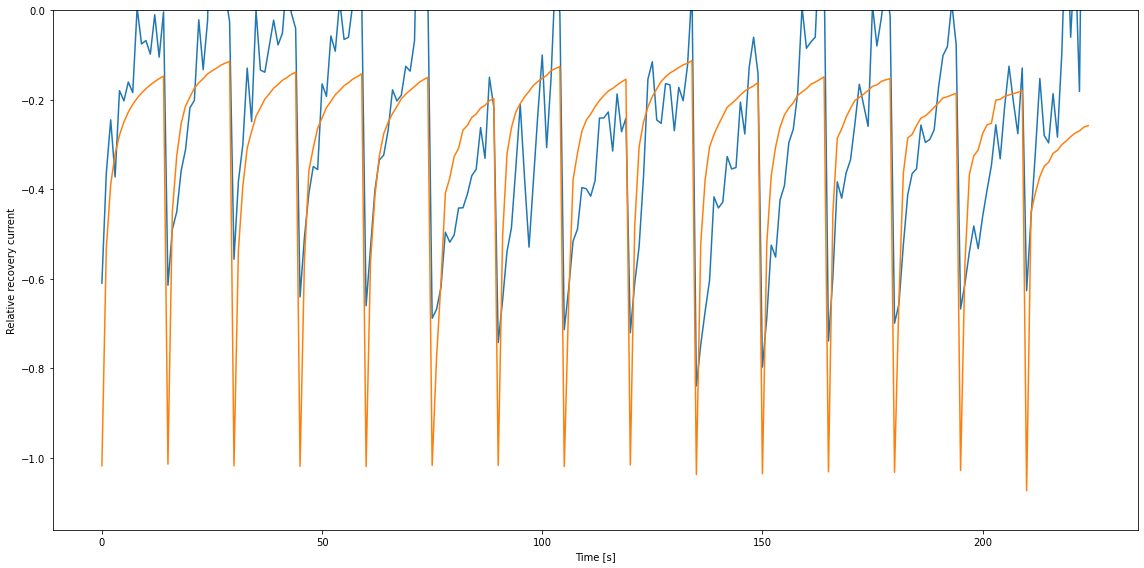

In [69]:
plt.figure(figsize=(16,8))
plt.plot(fit_result["loss_1_rs6"][1])
plt.plot(fit_result["loss_1_rs6"][2])


plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")
plt.tight_layout()

In [70]:
fit_result["loss_1_rs4"][0]

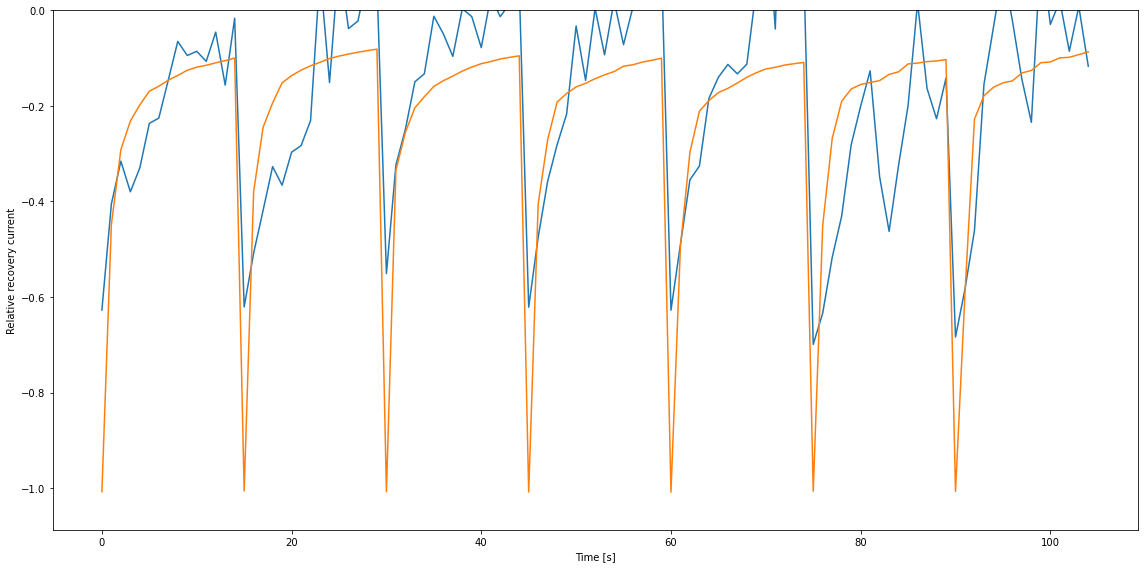

In [71]:
plt.figure(figsize=(16,8))
plt.plot(fit_result["loss_1_rs4"][1])
plt.plot(fit_result["loss_1_rs4"][2])

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")
plt.tight_layout()

In [72]:
fit_result["loss_2_rs9"][0]

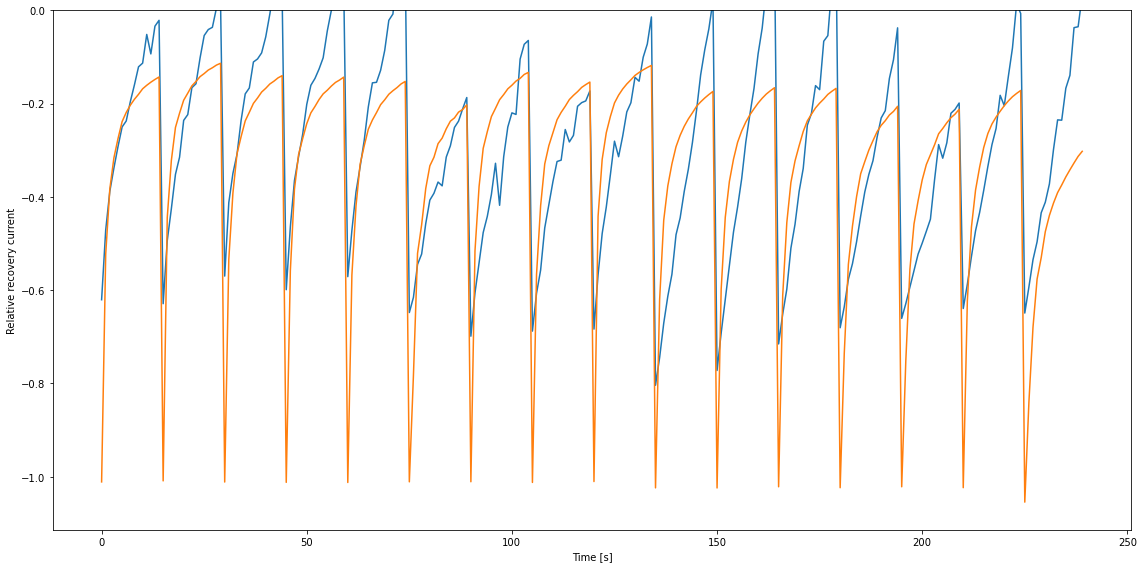

In [73]:
plt.figure(figsize=(16,8))
plt.plot(fit_result["loss_2_rs9"][1])
plt.plot(fit_result["loss_2_rs9"][2])

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")
plt.tight_layout()

In [74]:
fit_result["loss_2_rs6"][0]

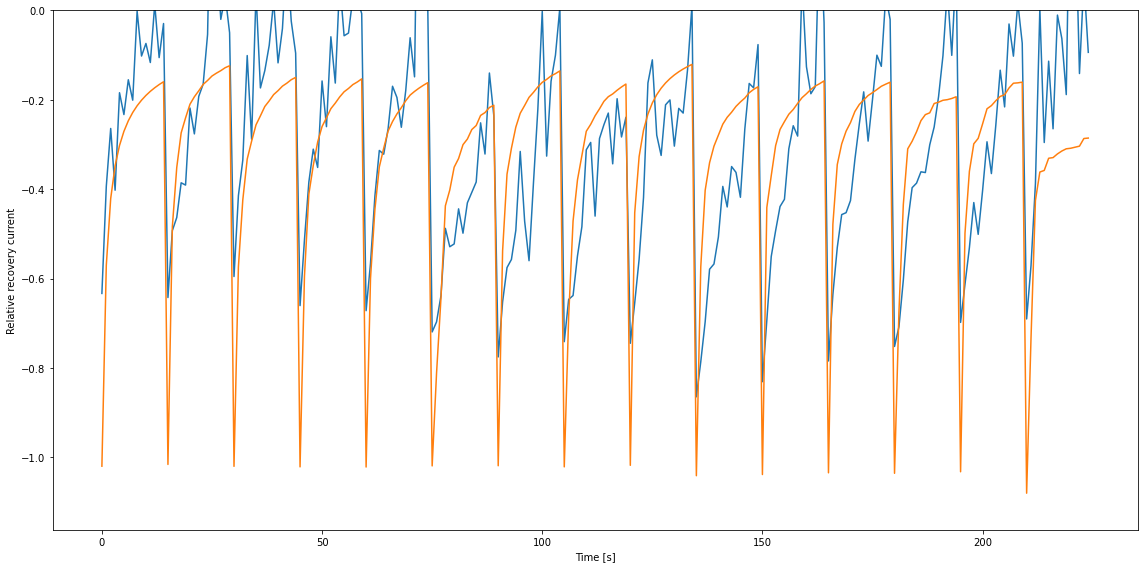

In [75]:
plt.figure(figsize=(16,8))
plt.plot(fit_result["loss_2_rs6"][1])
plt.plot(fit_result["loss_2_rs6"][2])
plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")
plt.tight_layout()

In [76]:
fit_result["loss_2_rs4"][0]

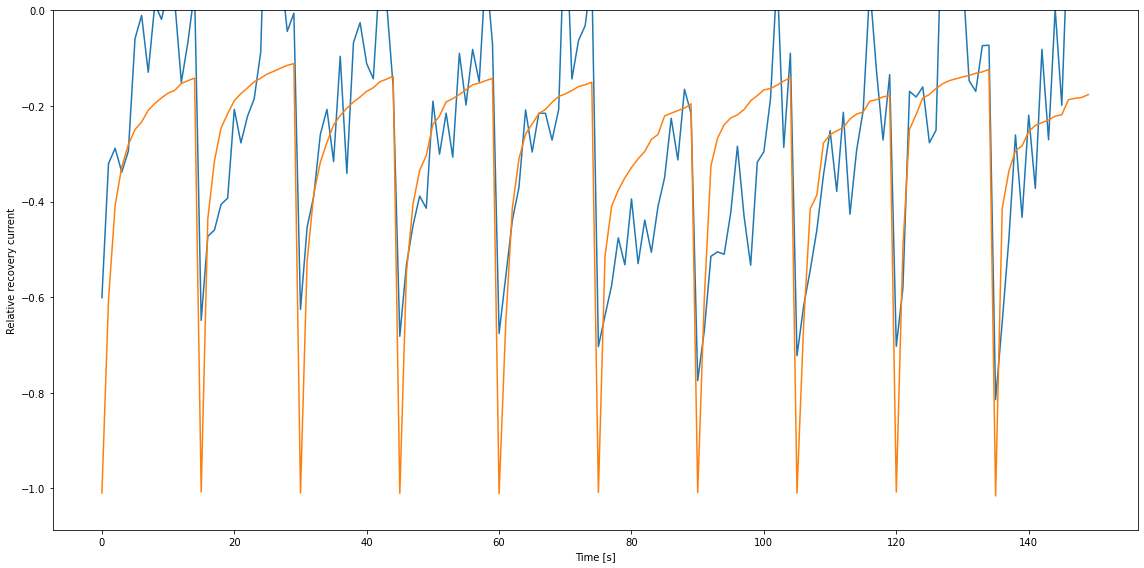

In [77]:
plt.figure(figsize=(16,8))
plt.plot(fit_result["loss_2_rs4"][1])
plt.plot(fit_result["loss_2_rs4"][2])

plt.ylim(top=0.0)
plt.xlabel("Time [s]")
plt.ylabel("Relative recovery current")
plt.tight_layout()